In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera
from sionna.rt.utils import r_hat
from sionna.ofdm import ResourceGrid
from sionna.channel.utils import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.constants import SPEED_OF_LIGHT

In [3]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars)
scene.add(Camera("cam", position=[50,0,130], look_at=[10,0,0]))
if no_preview:
    scene.render(camera="cam", num_samples=512);

In [4]:
%%skip_if no_preview
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [5]:
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x7eeae0181330>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x7eeae01817b0>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x7eeae0181090>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x7eeae0181780>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x7eeae01818d0>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x7eeae0181990>,
 'car_1': <sionna.rt.scene_object.SceneObject at 0x7eeae0181150>,
 'car_2': <sionna.rt.scene_object.SceneObject at 0x7eeae01811e0>,
 'car_3': <sionna.rt.scene_object.SceneObject at 0x7eeae0180a60>,
 'car_4': <sionna.rt.scene_object.SceneObject at 0x7eeae0180d90>,
 'car_5': <sionna.rt.scene_object.SceneObject at 0x7eeae0180880>,
 'car_6': <sionna.rt.scene_object.SceneObject at 0x7eeae0180a90>,
 'car_7': <sionna.rt.scene_object.SceneObject at 0x7eeae0180bb0>,
 'car_8': <sionna.rt.scene_object.SceneObject at 0x7eeae0180c10>,
 'floor': <sionna.rt.scene_object.SceneObject 

In [6]:
car_2 = scene.get("car_2")
print("Position: ", car_2.position.numpy())
print("Orientation: ", car_2.orientation.numpy())

Position:  [25.         5.5999994  0.7500001]
Orientation:  [0. 0. 0.]


In [7]:
# Move the car 10m along the y-axis
car_2.position += [0, 10, 0]

# And rotate it by 90 degree around the z-axis
car_2.orientation = [np.pi/2, 0, 0]

if no_preview:
    scene.render(camera="cam", num_samples=512);
else:
    scene.preview(); # You do not need to open a new preview, the preview above will update

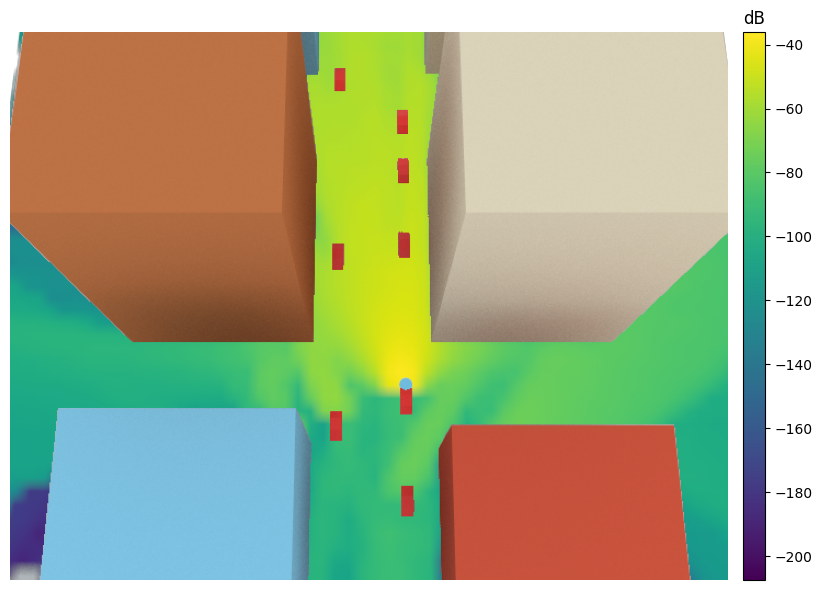

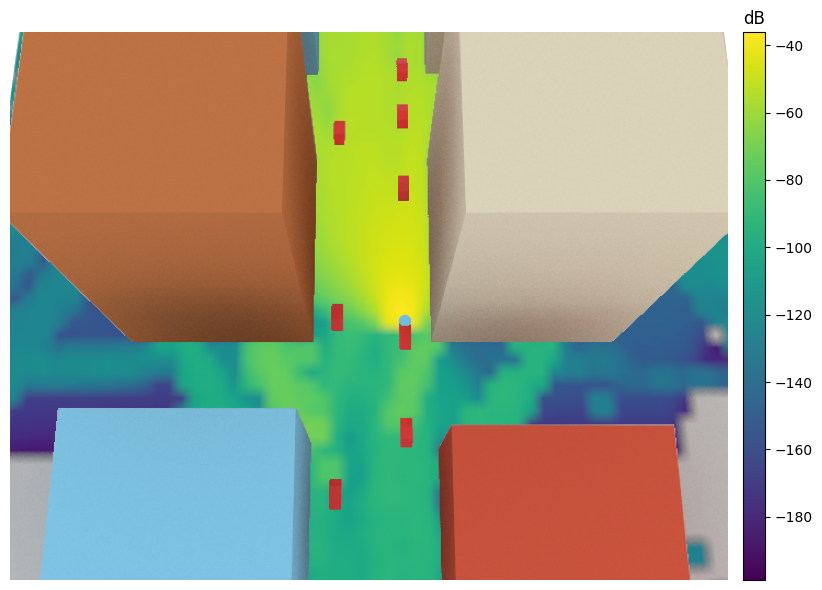

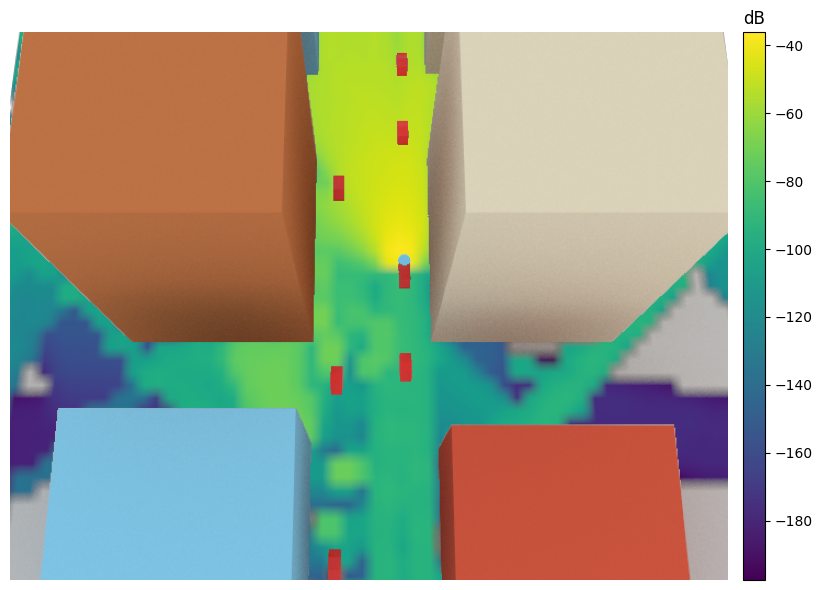

In [8]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars)
scene.add(Camera("cam", position=[50,0,130], look_at=[10,0,0]))

# Configure a transmitter that is located at the front of "car_2"
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.tx_array = PlanarArray(1,1,0.5,0.5,"tr38901","V")
scene.rx_array = scene.tx_array

# Move cars along straight lines for a couple of steps
displacement_vec = [10, 0, 0]
num_displacements = 2
for _ in range(num_displacements+1):

    # Compute and render a coverage map at 0.5m above the ground
    cm = scene.coverage_map(num_samples=10e6,
                            max_depth=5,
                            diffraction=True,
                            cm_center=[0,0,0.5],
                            cm_orientation=[0,0,0],
                            cm_size=[186,121],
                            cm_cell_size=[2,2])
    scene.render("cam", coverage_map=cm)

    # Move TX to next position
    scene.get("tx").position -= displacement_vec

    # Move cars driving in -x direction
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in x direction
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

In [9]:
# Load scene with a single reflector
scene = load_scene(sionna.rt.scene.simple_reflector)

# Inspect the velocity of this object
print("Velocity vector: ", scene.get("reflector").velocity.numpy())

# Update velocity vector
scene.get("reflector").velocity = [0, 0, -20]
print("Velocity vector after update: ", scene.get("reflector").velocity.numpy())

Velocity vector:  [0. 0. 0.]
Velocity vector after update:  [  0.   0. -20.]


In [10]:
# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso","V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [-25,0.1,50]))
scene.add(Receiver("rx",    [ 25,0.1,50]))

# Compute paths
paths = scene.compute_paths(max_depth=1)
paths.normalize_delays = False # Do not normalize the delays such that the first path arrives at tau=0

# Visualize the scene and propagation paths
if no_preview:
    scene.add(Camera("cam", position=[0, 100, 50], look_at=[0,0,30]))
    scene.render(paths=paths, camera="cam", num_samples=512);
    

In [11]:
%%skip_if no_preview
scene.preview(paths=paths)


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [12]:
print("Path type (0=LoS, 1=Specular reflection): ", paths.types.numpy())
print("Doppler shifts (Hz): ", paths.doppler.numpy())

Path type (0=LoS, 1=Specular reflection):  [[0 1]]
Doppler shifts (Hz):  [[[[   0.      -417.68832]]]]


In [13]:
rg = ResourceGrid(num_ofdm_symbols=1024,
                  fft_size=1024,
                  subcarrier_spacing=30e3)

delay_resolution = rg.ofdm_symbol_duration/rg.fft_size
print("Delay   resolution (ns): ", int(delay_resolution/1e-9))

doppler_resolution = rg.subcarrier_spacing/rg.num_ofdm_symbols
print("Doppler resolution (Hz): ", int(doppler_resolution))

Delay   resolution (ns):  32
Doppler resolution (Hz):  29


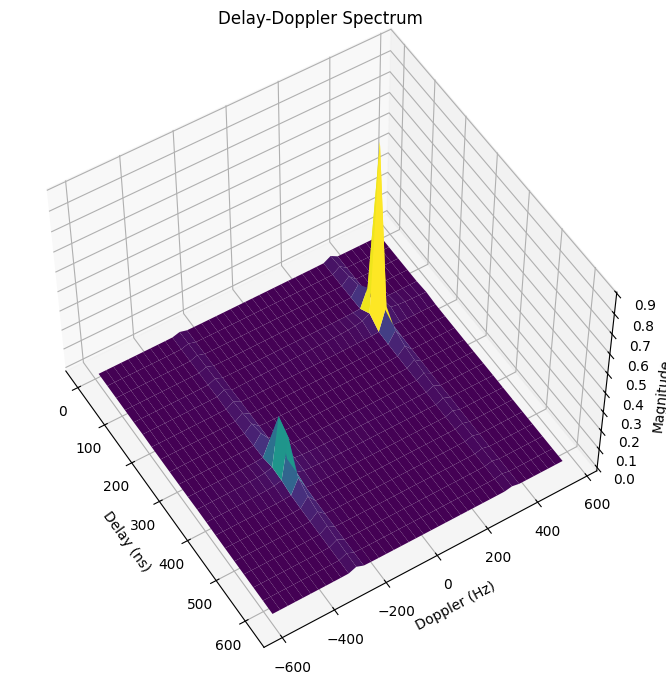

In [15]:
# Compute time evolution of the channel impulse response
tx_velocity = [30,0,0]
paths.apply_doppler(sampling_frequency=1/rg.ofdm_symbol_duration,
                    num_time_steps=rg.num_ofdm_symbols,
                    tx_velocities=tx_velocity)


### Compute the Delay-Doppler spectrum
# Determine subcarrier frequencies
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

# Squeeze useless dimensions
# [num_time_steps, fft_size]
h = tf.squeeze(cir_to_ofdm_channel(frequencies, *paths.cir(), normalize=True))

# Apply an FFTshift to bring subcarriers in the
# correct order for an IFFT
h = np.fft.fftshift(h, axes=1)

# Apply IFFT to subcarrier dimension to
# convert frequency to delay domain
h_delay = np.fft.ifft(h, axis=1)/np.sqrt(rg.fft_size)

# Apply FFT to time-step dimension to
# convert time to Doppler domain
h_delay_doppler = np.fft.fft(h_delay, axis=0)/np.sqrt(rg.fft_size)

# Apply FFTShift to bring Doppler dimension in the correct
# order for visualization
h_delay_doppler = np.fft.fftshift(h_delay_doppler, axes=0)

# Compute meshgrid for visualization of the Delay-Doppler spectrum
doppler_bins = np.arange(-rg.num_ofdm_symbols/2*doppler_resolution,
                          rg.num_ofdm_symbols/2*doppler_resolution,
                         doppler_resolution)

delay_bins = np.arange(0,
                       rg.fft_size*delay_resolution,
                       delay_resolution) / 1e-9

x, y = np.meshgrid(delay_bins, doppler_bins)

# Visualize Delay-Doppler spectrum
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# We only visualize the relevant part of the spectrum
offset = 20
x_start = int(rg.fft_size/2)-offset
x_end = int(rg.fft_size/2)+offset
y_start = 0
y_end = offset
x_grid = x[x_start:x_end,y_start:y_end]
y_grid = y[x_start:x_end,y_start:y_end]
z_grid = np.abs(h_delay_doppler[x_start:x_end,y_start:y_end])

surf = ax.plot_surface(x_grid,
                       y_grid,
                       z_grid,
                       cmap='viridis', edgecolor='none')

ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Doppler (Hz)')
ax.set_zlabel('Magnitude');
ax.zaxis.labelpad=2
ax.view_init(elev=53, azim=-32)
ax.set_title("Delay-Doppler Spectrum");

In [16]:
# Compute outgoing directions for the LoS and reflected path
k_t_los = r_hat(paths.theta_t[0,0,0,0], paths.phi_t[0,0,0,0])
k_t_ref = r_hat(paths.theta_t[0,0,0,1], paths.phi_t[0,0,0,1])

# Compute the Doppler shifts due to movement of the transmitter
doppler_tx_los = np.sum(k_t_los*tx_velocity)/scene.wavelength
doppler_tx_ref = np.sum(k_t_ref*tx_velocity)/scene.wavelength

# Compute the overall Doppler shifts
doppler_los = doppler_tx_los + paths.doppler[0,0,0,0]
doppler_ref = doppler_tx_ref + paths.doppler[0,0,0,1]

print("Delay - LoS Path (ns) :", paths.tau[0,0,0,0].numpy()/1e-9)
print("Doppler - LoS Path (Hz) :", doppler_los.numpy())

print("Delay - Reflected Path (ns) :", paths.tau[0,0,0,1].numpy()/1e-9)
print("Doppler - Reflected Path (Hz) :", doppler_ref.numpy())

Delay - LoS Path (ns) : 166.78205838616122
Doppler - LoS Path (Hz) : 350.2423
Delay - Reflected Path (ns) : 372.93600030352536
Doppler - Reflected Path (Hz) : -261.05524


In [17]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars)
scene.add(Camera("cam", position=[50,0,130], look_at=[10,0,0]))

# Parameters for ray tracing
max_depth = 3
diffraction = True

# TX and RX have directional antennas
scene.tx_array = PlanarArray(1,1,0.5,0.5,"tr38901","V")
scene.rx_array = scene.tx_array

# TX and RX are installed at the front of two different cars.
# The directive antennas ensure that paths reaching an antenna from the back are close to zero.
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.add(Receiver("rx", position=[-27.8,-4.9, 0.75]))

# Configure an OFDM resource grid
rg = ResourceGrid(num_ofdm_symbols=128,
                  fft_size=1024,
                  subcarrier_spacing=30e3)

frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

# Define a velocity vector and the corresponding displacement over the duration
# of one OFDM symbol
velocity_vec = np.array([10,0,0])
displacement_vec = velocity_vec*rg.ofdm_symbol_duration

# Assign velocity vector to cars driving in -x direction
for j in range(1,6):
    scene.get(f"car_{j}").velocity = -velocity_vec

# Assign velocity vector to cars driving in x direction
for j in range(6,9):
    scene.get(f"car_{j}").velocity = velocity_vec

# Compute paths and apply Doppler shift for time evolution
paths = scene.compute_paths(max_depth=max_depth, diffraction=diffraction)
paths.normalize_delays = False
paths.apply_doppler(sampling_frequency=1/rg.ofdm_symbol_duration,
                    num_time_steps=rg.num_ofdm_symbols,
                    tx_velocities=-velocity_vec,
                    rx_velocities=velocity_vec)

# Compute the corresponding channel frequency responses
h_dop = tf.squeeze(cir_to_ofdm_channel(frequencies, *paths.cir()))

# Visualize the scene and propagation paths
if no_preview:
    scene.render(paths=paths, camera="cam", num_samples=512);

In [18]:
%%skip_if no_preview
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [19]:
paths = scene.compute_paths(max_depth=max_depth, diffraction=diffraction)
paths.normalize_delays = False
# Reshape to [1, num_subcarriers]
h_sim = tf.reshape(cir_to_ofdm_channel(frequencies, *paths.cir()), [1, -1])

for i in range(rg.num_ofdm_symbols-1):
    # Move TX and RX to next position
    scene.get("tx").position -= displacement_vec
    scene.get("rx").position += displacement_vec

    # Move cars driving in -x direction to the next position
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in +x direction to the next position
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

    # Compute channel frequency response
    paths = scene.compute_paths(max_depth=max_depth, diffraction=diffraction)
    paths.normalize_delays = False
    h = tf.reshape(cir_to_ofdm_channel(frequencies, *paths.cir()), [1, -1])

    # Concatenate along the time dimensions
    h_sim = tf.concat([h_sim, h], axis=0)

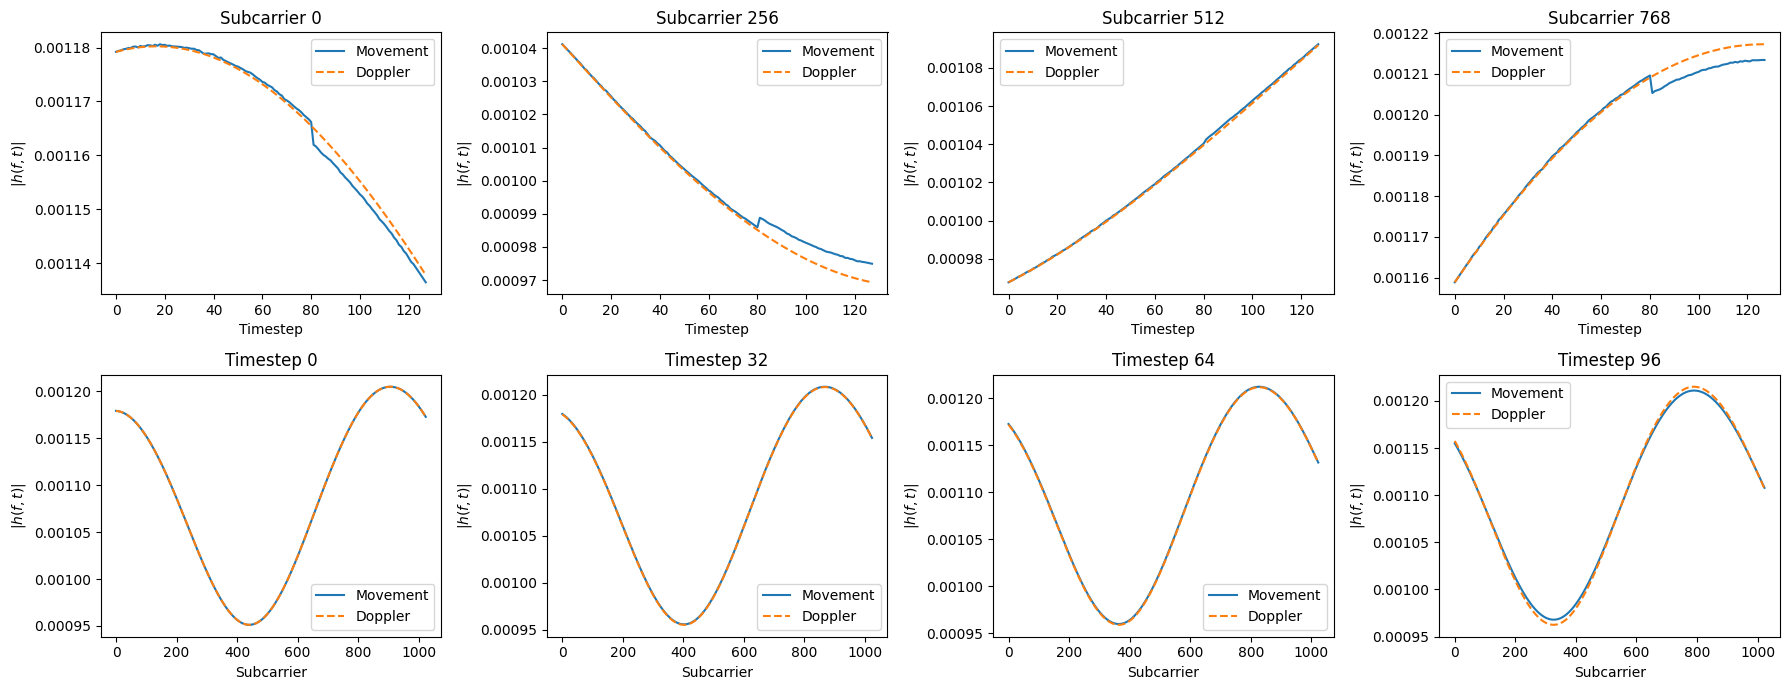

In [20]:
subcarriers = np.arange(0, 1024, 256)
timesteps =  np.arange(0, 128, 32)

fig, axs = plt.subplots(2, 4, figsize=(18, 7))
for i,j in enumerate(subcarriers):
    axs[0,i].plot(np.arange(rg.num_ofdm_symbols), np.abs(h_sim[:,j]))
    axs[0,i].plot(np.arange(rg.num_ofdm_symbols), np.abs(h_dop[:,j]), "--")
    axs[0,i].set_xlabel("Timestep")
    axs[0,i].set_ylabel(r"$|h(f,t)|$")
    axs[0,i].set_title(f"Subcarrier {j}")
    axs[0,i].legend(["Movement", "Doppler"])


for i,j in enumerate(timesteps):
    axs[1,i].plot(np.arange(rg.fft_size), np.abs(h_sim[j,:]))
    axs[1,i].plot(np.arange(rg.fft_size), np.abs(h_dop[j,:]), "--")
    axs[1,i].set_xlabel("Subcarrier")
    axs[1,i].set_ylabel(r"$|h(f,t)|$")
    axs[1,i].set_title(f"Timestep {j}")
    axs[1,i].legend(["Movement", "Doppler"])

plt.tight_layout()
plt.show()